Learn the inter-grid operator ratio for interface problems using multigrid framework,
* Dataset is constructed by changing RHS 
* Restriction and Prolongation operations are followed by a split operation
* Kernels for some part of fields are learned 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from FEANet.multigrid import MultiGrid

from Utils import plot
from Data.dataset import RHSDataSet

In [2]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
linear_tensor_R = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 16.0
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_ratio = torch.asarray([4.,1.], dtype=torch.float32)

In [4]:
n = 2**4
model = MultiGrid(n, linear_tensor_R, linear_tensor_P, linear_ratio)
rhs = next(iter(train_dataloader))

0 0.0008530860068276525
1 0.00024632076383568347
2 8.343508670805022e-05
3 2.9828441256540827e-05
Solution converges after 4 multi-grid iterations 


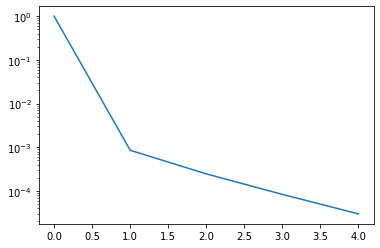

In [5]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[1].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [6]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][0])
print('Restriction kernel shape:', mlist[1].shape)
print('Interpolation kernel:', mlist[2][0][0])
print('Interpolation kernel shape:', mlist[2].shape)

Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 16, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel shape: torch.Size([16, 1, 3, 3])


In [7]:
def freeze_kernels(para_list, list):
    '''Freeze the kernels in list, second and third term are R and P'''
    for i in list:
        para_list[1].grad[:,i] = torch.zeros_like(para_list[1].grad[:,i])
        para_list[2].grad[i,:] = torch.zeros_like(para_list[2].grad[i,:])
        

def rewrite_kernels(para_list, list, kernels):
    '''Overwrite the kernels in list to be 'kernels', second and third term are R and P '''
    for i in list:
        para_list[1].grad[:,i] = kernels[0]
        para_list[2].grad[i,:] = kernels[1]

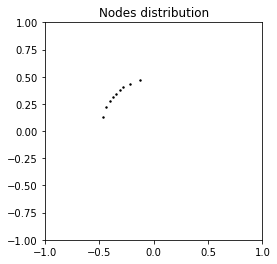

In [8]:
kernel_i = 12
mesh = MeshHandler(outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=kernel_i)

In [9]:
freeze_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # freeze a kernel
freeze_list.remove(kernel_i)

def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        para_list = list(model.parameters())
        # freeze parts of the grad to be zeros, e.g., param.grad[:,1:] = torch.zeros_like(param.grad[:,1:])
        freeze_kernels(para_list, freeze_list)
        optimizer.step()
        # overwrite the new param to be the original weight
        rewrite_kernels(para_list, freeze_list, [linear_tensor_R, linear_tensor_P])
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [10]:
num_epoch = 300
best_vloss = 1_000_000.
model_name = 'model_multigrid_interface_kernel'+str(kernel_i)

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

0 0.41126375645399094
1 0.41689118184149265
2 0.42074258625507355
3 0.42903608083724976
4 0.43325703777372837
5 0.4394267201423645
6 0.44447704218328
7 0.44825844652950764
8 0.44921439699828625
9 0.450447253882885
10 0.4545490462332964
11 0.45368944481015205
12 0.4568483028560877
13 0.4554218389093876
14 0.45735666900873184
15 0.45824332162737846
16 0.4611912611871958
17 0.46581763587892056
18 0.4623162429779768
19 0.4674090091139078
20 0.4670200739055872
21 0.4707312285900116
22 0.4690148402005434
23 0.46699731424450874
24 0.46704418025910854
25 0.4697952847927809
26 0.46917487122118473
27 0.46815630979835987
28 0.47169711627066135
29 0.4698252063244581
30 0.46951029263436794
31 0.47243802808225155
32 0.475046131759882
33 0.473667049780488
34 0.4711140375584364
35 0.4733977075666189
36 0.4740242213010788
37 0.4763975888490677
38 0.4739210419356823
39 0.4767931830137968
40 0.47558545134961605
41 0.4782820902764797
42 0.479635426774621
43 0.47807777486741543
44 0.47256255336105824
45 0.

Text(0.5, 0, 'epoch')

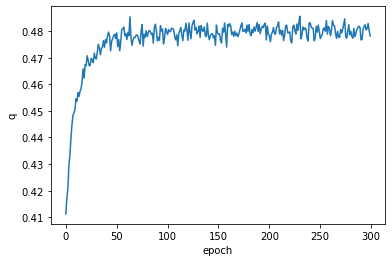

In [11]:
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [12]:
# save the list
np.save(os.path.join(model_dir,model_name+'.npy'),qm_train)

In [13]:
print('Learned parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i])
print('Interpolation kernel:', mlist[2][kernel_i][0])

print()

print('Previous parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i-1])
print('Interpolation kernel:', mlist[2][kernel_i-1][0])


Learned parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[-0.7691,  0.3702,  0.2362],
        [ 0.3732,  0.2500,  0.3662],
        [ 0.2361,  0.3684, -0.3561]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2668, 0.5094, 0.2778],
        [0.5096, 0.9845, 0.5173],
        [0.2777, 0.5171, 0.3441]], grad_fn=<SelectBackward0>)

Previous parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)


In [14]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

In [15]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.08498585969209671
1 0.03980517387390137
2 0.017964793369174004
3 0.007922661490738392
4 0.003488012822344899
5 0.0015441548312082887
6 0.0006875990657135844
7 0.00030746764969080687
8 0.0001377689332002774
9 6.192467117216438e-05
10 2.812931234075222e-05
Solution converges after 11 multi-grid iterations 


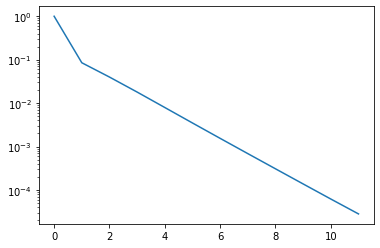

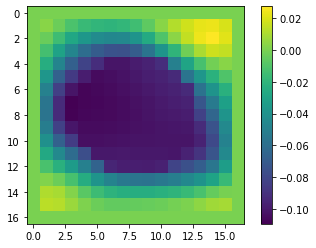

In [16]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [17]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_R, linear_tensor_P, linear_ratio)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w
        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.w.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.15113717317581177
0.17160780883990245 0.07476160675287247
0.027066211807825903 0.037302833050489426
0.01027765858331983 0.019919494166970253
0.011717275089014639 0.011764800176024437
0.006674178614841533 0.007594882044941187
0.0025058199272735052 0.005235332529991865
0.0003767427203619385 0.003770967712625861
0.00042736737096830263 0.002777347108349204
0.0005498881565294369 0.002055399352684617
0.0004708205826649189 0.0015201159985736012
0.0003513030285120221 0.0011201794259250164
0.0002384041613820316 0.000822827685624361
0.00016689781077027633 0.0006026267074048519
0.00011397297371753383 0.0004421987687237561
8.559376187133973e-05 0.00032379169715568423
6.356103396122318e-05 0.00023961231636349112
5.723582165357652e-05 0.00017658199067227542
3.7357328186666714e-05 0.00012979880557395518
2.9220544413042216e-05 9.696045890450478e-05
1.2078668491052397e-05 6.963207124499604e-05
1.6858738981325168e-05 5.1243972848169506e-05
1.4178661976740282e-05 3.88913722417783e-05
Solution conve

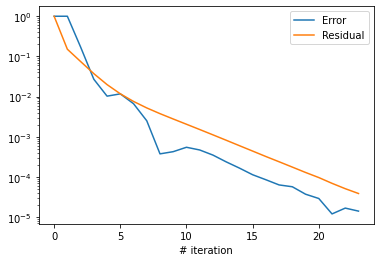

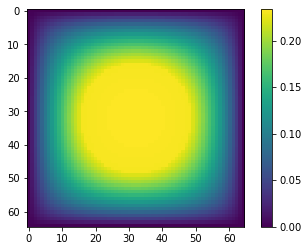

In [18]:
# Multigrid implementation
n = 2**6
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [19]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.7776376547441867
